# Final Project: Fake News Detection

By Felix Daubner - Hochschule der Medien

Module 'Supervised and Unsupervised Learning' - Prof. Dr.-Ing. Johannes Maucher

## Model Training

In [1]:
import pandas as pd
import numpy as np
import altair as alt
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow import keras
from keras.models import Model
from keras.layers import Embedding, Flatten, Dense, LSTM, Conv1D, Flatten, MaxPooling1D, Dropout, Bidirectional, Input, Concatenate
from sklearn.metrics import confusion_matrix

import pickle
from gensim.models import KeyedVectors

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, Trainer

NUM_WORDS=3000
MAX_SEQUENCE_LEN = 57
NUM_CAT = 20

In [2]:
def prepareFeatures(X):
    '''
    This function gets the features and modifies the features in a way to be able to train neural network
    using encoded categorical data and tokenized text.
    Returns numpy arrays.
    '''
    X_token = np.array(X["token"].apply(np.asarray))
    X_token = np.array([arr for arr in X_token])

    X_enc = np.array(X.drop(["token"], axis=1).apply(np.array))

    return X_token, X_enc

def prepareTarget(y):
    '''
    This function returns the target data as a numpy array.
    '''
    return np.array(y)

def visualizeHistory(history):
    '''
    This function gets keras.History object and plots loss, validation loss, precision and validation precision.
    Returns altair hconcat object containing the charts.
    '''

    l, p, v_l, v_p = history.history.keys()

    data = pd.DataFrame({"epoch": history.epoch,
            "loss": history.history[l],
            "val_loss": history.history[v_l],
            "precision": history.history[p],
            "val_precision": history.history[v_p]})
    
    loss_min = min(data["loss"].min(), data["val_loss"].min())
    loss_max = max(data["loss"].max(), data["val_loss"].max())

    precision_min = min(data["precision"].min(), data["val_precision"].min())
    precision_max = max(data["precision"].max(), data["val_precision"].max())

    data_melted = data.melt('epoch', value_vars=['loss', 'val_loss', 'precision', 'val_precision'], var_name='type', value_name='value')
    
    data_loss = data_melted[data_melted["type"].isin(["loss", "val_loss"])]
    loss = alt.Chart(data_loss).mark_line().encode(
        x = "epoch",
        y = alt.Y("value", scale = alt.Scale(domain=[loss_min, loss_max])),
        color = alt.Color("type", legend=alt.Legend(orient="right"))
    ).properties(
        title = "Training and Validation Loss over epochs"
    )

    data_precision = data_melted[data_melted["type"].isin(["precision", "val_precision"])]
    precision = alt.Chart(data_precision).mark_line().encode(
        x = "epoch",
        y = alt.Y("value", scale = alt.Scale(domain=[precision_min, precision_max])),
        color = alt.Color("type", legend=alt.Legend(orient="right"))
    ).properties(
        title = "Training and Validation Precision over epochs"
    )

    return alt.hconcat(loss, precision).resolve_scale(color="independent")


def performanceReport(model, X_train, y_train, X_val, y_val):
    '''
    This function gets a model, training and validation data.
    It predicts training and validation data, compares it to the true data and prints out classification report for both, training and validation.
    '''
    y_pred_train = (model.predict(X_train) > 0.5).astype(int)
    y_pred_val = (model.predict(X_val) > 0.5).astype(int)

    print("\nClassifcation Report of Performance on Training data")
    print(classification_report(y_train, y_pred_train))
    
    print("\n")
    print("* "*10)

    print("\nClassifcation Report of Performance on Validation data")
    print(classification_report(y_val, y_pred_val))

This section contains the model definition and training. Different types of models should be trained and then compared in their performances to find out which model fits the challenge, to determine whether a political statement was fake-news or true, best. 

There are four types of models to be compared: a feedforward neural network, a Long Short-Term Memory, a bidirectional Long Short-Term Memory and Convolutional Neural Network. Those models will vary in terms of layers and hyperparameters still trying to keep them rather simple. All models are trained using the encoded categorical data of 'channel' and the tokenized statements including stop words. All models are then trained using 20 epochs and a batch size of 128. 

The best model is evaluated based on training and validation performance. At the end, the best model in terms of complexity and performance is chosen and will be optimized further.

### Prepare data for training and validation

As the training and validation data is the same for every model, the preparation of the preprocessed data resulting in a structure able to train different kinds of neural networks, is only needed to be done once.

In [3]:
data = pd.read_json("data/processed.json", orient="records", lines=True)

In [4]:
data.columns

Index(['statement', 'channel_Instagram', 'channel_Other', 'channel_TV',
       'channel_TikTok', 'channel_X', 'channel_ad', 'channel_article',
       'channel_blog', 'channel_campaign', 'channel_debate',
       'channel_interview', 'channel_lecture', 'channel_mail',
       'channel_podcast', 'channel_presentation', 'channel_press',
       'channel_social media', 'channel_speech', 'channel_talk',
       'channel_video', 'truth', 'token', 'statement_stop', 'token_stop'],
      dtype='object')

Before starting defining the different models, the data is prepared for the training process. The neural networks to be trained only take numpy arrays as input. Thus, the data currently saved as a pandas DataFrame is converted in to a numpy array. In this conversion process, only "token", the encoded "channel" columns and "truth" are kept.

In [5]:
X = data.drop(["statement", "statement_stop", "token_stop", "truth"], axis=1)
y = data["truth"]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=42)

After splitting the data into features and target, the features still have to preprared for training by splitting the encoded categorical data from the tokenized statements. The tokenized text data has to be taken care of using an Embedding Layer while a Dense layer is sufficient to handle the encoded categorical data.

In [7]:
X_train_token, X_train_enc = prepareFeatures(X_train)
X_val_token, X_val_enc = prepareFeatures(X_val)
y_train = prepareTarget(y_train)
y_val = prepareTarget(y_val)

### Prepare infrastructure

Still, the data despite being prepared to fit the structure of neural networks, is not ready for training yet. The tokenized statements saved in "X_train_token" and "X_val_token" need to be transformed into an embedding matrix which assigns every word / token a vector. This vector represents the word in a multi-dimensional vector space and models the relationship between different words.

A pre-trained word embedding from FastText which already contains the vectors for each word is used to create the embedding matrix.

In [8]:
word2vec = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec")

Also, to remember the words which are placed behind each token, the trained 'tokenizer'-object of section [data pre-processing](03_data-understanding.ipynb) is imported using pickle.

In [9]:
with open("tokenizer/tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)

The following code creates an embedding matrix which assigns every word their respective vector as saved in the pre-trained word embedding of FastText.

In [10]:
embedding_dim = 300  
word_index = tokenizer.word_index 
num_words = min(len(word_index) + 1, NUM_WORDS)  

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        if word in word2vec.key_to_index:
            embedding_vector = word2vec[word]
            embedding_matrix[i] = embedding_vector

For every kind of model which is going to be trained in the following, two input layers are defined. Those two input layers are the same used for every kind of model as the input data doesn't vary between types of models.

There is one input layer for tokenized text data and another input layer for encoded categorical data.

In [11]:
text_input = Input(shape=(MAX_SEQUENCE_LEN,), name="text_input")
categorical_input = Input(shape=(NUM_CAT,), name="categorical_input")

Using the input layer and embedding matrix, an Embedding layer can be set up.

In [12]:
emb = Embedding(NUM_WORDS, embedding_dim, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LEN, trainable=False)(text_input)

To handle the encoded categorical data, a dense layer is sufficient.

In [13]:
cat = Dense(32, activation="relu")(categorical_input)

## Model training

When looking at fake-news detection, it is decided which metric should be optimized. Classification provide a lots of useful metrics which have to be chosen for each project individually. The most common and known metrics are accuracy, precision, recall and f1-score.

Most often, accuracy is not a good metric as it doesn't take into account the cost of predicting errors. That's why either precision or recall should be used.

The worst case at fake-news prediction is when a fake-news statement is not identified as fake-news but as true. Whereas the other way, a true statement being classified as fake-news statement does not harm in the same way. Translating this into the terms of this project means a false positive ("a statement which is 'fake' (0) gets classified as 'true' (1)") is worse than a false negative ("a statement which is 'true' (1) gets classified as 'false' (0)"). The metrics focusing on optimizing the false positives is precision. Therefore, precision is used when trying to chose and optimize a fake-news classification model.

In the following, four different types models are trained and evaluated. Based on those evaluations, the best model is chosen. 

All models are designed in a way so that the number of trainable parameters are in the same region to being able to compare the results of the models. The evaluations of the models after each respective training are kept short as the focus lays on the displayed metrics. In the next chapter discusses the model to keep by relying on the previously achieved metrics.

### Feedforward Neural Nerwork

The first model to be trained is a simple feedforward neural network. The feedforward neural network consists of Dense and Dropout layers which make the architecture quite easy and not too complex.

In [14]:
ff_flatten_text = Flatten()(emb)

ff_combined = Concatenate()([ff_flatten_text, cat])
ff_dense1 = Dense(32, activation="relu")(ff_combined)
ff_drop = Dropout(0.4)(ff_dense1)
ff_dense2 = Dense(16, activation="relu")(ff_drop)
ff_output = Dense(1, activation="sigmoid")(ff_dense2)

In [15]:
ff = Model(inputs=[categorical_input, text_input], outputs=ff_output)
ff.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 57)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 57, 300)      900000      ['text_input[0][0]']             
                                                                                                  
 categorical_input (InputLayer)  [(None, 20)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 17100)        0           ['embedding[0][0]']              
                                                                                              

For every model, the optimizer "sgd" (Stochastic Gradient Descent) is used. Also, for binary classification the loss function "binary_crossentropy" is the one to use.

In [16]:
ff.compile(optimizer="sgd", loss="binary_crossentropy", metrics=[keras.metrics.Precision()])

In [17]:
ff_hist = ff.fit([X_train_enc, X_train_token], y_train, epochs=20, batch_size=128, validation_data=([X_val_enc, X_val_token], y_val))

Epoch 1/20


2025-01-19 21:04:04.458838: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


111/111 [==============================] - 1s 5ms/step - loss: 0.6926 - precision: 0.5160 - val_loss: 0.6891 - val_precision: 0.5240
Epoch 2/20
111/111 [==============================] - 0s 4ms/step - loss: 0.6865 - precision: 0.5570 - val_loss: 0.6826 - val_precision: 0.5511
Epoch 3/20
111/111 [==============================] - 0s 3ms/step - loss: 0.6793 - precision: 0.5811 - val_loss: 0.6757 - val_precision: 0.5670
Epoch 4/20
111/111 [==============================] - 0s 3ms/step - loss: 0.6729 - precision: 0.5989 - val_loss: 0.6696 - val_precision: 0.5767
Epoch 5/20
111/111 [==============================] - 0s 3ms/step - loss: 0.6677 - precision: 0.6112 - val_loss: 0.6646 - val_precision: 0.5843
Epoch 6/20
111/111 [==============================] - 0s 3ms/step - loss: 0.6630 - precision: 0.6182 - val_loss: 0.6580 - val_precision: 0.6000
Epoch 7/20
111/111 [==============================] - 0s 4ms/step - loss: 0.6575 - precision: 0.6315 - val_loss: 0.6519 - val_precision: 0.6142
Epo

After training the feedforward neural network, there are some things standing out.

As seen in the visualizatons below, both the training and validation loss decline per epoch. Same goes for precision which inclines per epoch. Both metrics show small signs of overfitting as the training metrics perform increasingly better compared to the validation metrics per epoch. Overfitting should be avoided as the performance on new, unseen data will be significantly worse than the performance on training data.

Also by using more epochs, the model can still be improved. Both loss and precision seem like with more epochs their values could still improve. 

In [18]:
visualizeHistory(ff_hist)

alt.HConcatChart(...)

When comparing the results of the classification report, the signs of overfitting can not be validated. The model performs already quite good with a weighted precision on the training data of 0.77, the weighted precision on the validation data is at 0.72. Due to the simple architecture of the model, the feedforward neural networks should considered when evaluating the best model. Though, as Feedforward Neural Network can not comprehend sequential data like texts, it should be discussed whether despsite the good results this model is kept.

In [19]:
performanceReport(ff, [X_train_enc, X_train_token], y_train, [X_val_enc, X_val_token], y_val)

190/190 [==============================] - 0s 786us/step

Classifcation Report of Performance on Training data
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      6972
           1       0.77      0.78      0.77      7144

    accuracy                           0.77     14116
   macro avg       0.77      0.77      0.77     14116
weighted avg       0.77      0.77      0.77     14116



* * * * * * * * * * 

Classifcation Report of Performance on Validation data
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      3111
           1       0.71      0.72      0.72      2939

    accuracy                           0.72      6050
   macro avg       0.72      0.72      0.72      6050
weighted avg       0.72      0.72      0.72      6050



### LSTM

Next type of model is a Long Short-Term Memory Neural Network. This type of neural network is more complex than a Feedforward Neural Networks as it can capture contextual information making it useful for sequential data like texts or time-sensitive data.

In [20]:
lstm_ = LSTM(256)(emb)

In [21]:
lstm_combined = Concatenate()([lstm_, cat])

In [22]:
lstm_dense1 = Dense(128, activation='relu')(lstm_combined)
lstm_drop1 = Dropout(0.4)(lstm_dense1)
lstm_dense2 = Dense(64, activation='relu')(lstm_drop1)
lstm_output = Dense(1, activation='sigmoid')(lstm_dense2)

In [23]:
lstm = Model(inputs=[categorical_input, text_input], outputs=lstm_output)
lstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 57)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 57, 300)      900000      ['text_input[0][0]']             
                                                                                                  
 categorical_input (InputLayer)  [(None, 20)]        0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 256)          570368      ['embedding[0][0]']              
                                                                                            

In [24]:
lstm.compile(optimizer="sgd", loss="binary_crossentropy", metrics=[keras.metrics.Precision()])

In [25]:
lstm_hist = lstm.fit([X_train_enc, X_train_token], y_train, batch_size=128, epochs=20, validation_data=([X_val_enc, X_val_token], y_val))

Epoch 1/20
111/111 [==============================] - 21s 177ms/step - loss: 0.6906 - precision_1: 0.5436 - val_loss: 0.6892 - val_precision_1: 0.5288
Epoch 2/20
111/111 [==============================] - 20s 176ms/step - loss: 0.6884 - precision_1: 0.5525 - val_loss: 0.6864 - val_precision_1: 0.5644
Epoch 3/20
111/111 [==============================] - 20s 177ms/step - loss: 0.6862 - precision_1: 0.5761 - val_loss: 0.6832 - val_precision_1: 0.5891
Epoch 4/20
111/111 [==============================] - 19s 172ms/step - loss: 0.6837 - precision_1: 0.5907 - val_loss: 0.6802 - val_precision_1: 0.6005
Epoch 5/20
111/111 [==============================] - 20s 182ms/step - loss: 0.6808 - precision_1: 0.6041 - val_loss: 0.6768 - val_precision_1: 0.6093
Epoch 6/20
111/111 [==============================] - 20s 179ms/step - loss: 0.6778 - precision_1: 0.6178 - val_loss: 0.6731 - val_precision_1: 0.6138
Epoch 7/20
111/111 [==============================] - 20s 182ms/step - loss: 0.6752 - precisio

The results of the LSTM Neural Network differ to the results of the Feedforward Neural Network. As seen in the Loss over Epochs plot, the validation loss is actually lower than the loss on the training data for all epochs. The precision on the training data is also lower for first 6 epochs. After a strong increase in precision in the first 6 epochs the increase per epoch over the remaining 14 epochs decreases.

There are no signs of overfitting as the training and validation move on equal levels.

In [26]:
visualizeHistory(lstm_hist)

alt.HConcatChart(...)

The classficiation reports show that training and validation data perform on an equal level, the validation even performing slightly better. The weighted precision value of the training data is at 0.69 which is worse compared to the feedforward neural network. Even though, a LSTM has a more complex architecture it is designed to specifically handle sequential input like texts. The performance compared to the Feedforward Neural Network might be worse, but not in a way which can not be fixed by optimizing hyperparameters.

In [27]:
performanceReport(lstm, [X_train_enc, X_train_token], y_train, [X_val_enc, X_val_token], y_val)

190/190 [==============================] - 6s 31ms/step

Classifcation Report of Performance on Training data
              precision    recall  f1-score   support

           0       0.73      0.59      0.65      6972
           1       0.66      0.78      0.72      7144

    accuracy                           0.69     14116
   macro avg       0.69      0.69      0.69     14116
weighted avg       0.69      0.69      0.69     14116



* * * * * * * * * * 

Classifcation Report of Performance on Validation data
              precision    recall  f1-score   support

           0       0.74      0.62      0.67      3111
           1       0.65      0.77      0.71      2939

    accuracy                           0.69      6050
   macro avg       0.70      0.69      0.69      6050
weighted avg       0.70      0.69      0.69      6050



### Bi-directional LSTM

A bidirectional LSTM compared to a standard LSTM processes the input in both forward and backward directions. This allows the model to capture past and future context at a time. The architecture againg being more complex to a LSTM and Feedforward Neural Network.

In [28]:
blstm_ = Bidirectional(LSTM(128))(emb)

In [29]:
blstm_combined = Concatenate()([blstm_, cat])

In [30]:
blstm_dense1 = Dense(128, activation='relu')(blstm_combined)
blstm_drop1 = Dropout(0.4)(blstm_dense1)
blstm_dense2 = Dense(32, activation='relu')(blstm_drop1)
blstm_output = Dense(1, activation='sigmoid')(blstm_dense2)

In [31]:
blstm = Model(inputs=[categorical_input, text_input], outputs=blstm_output)
blstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 57)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 57, 300)      900000      ['text_input[0][0]']             
                                                                                                  
 categorical_input (InputLayer)  [(None, 20)]        0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 256)          439296      ['embedding[0][0]']              
                                                                                            

In [32]:
blstm.compile(optimizer="sgd", loss="binary_crossentropy", metrics=[keras.metrics.Precision()])

In [33]:
blstm_hist = blstm.fit([X_train_enc, X_train_token], y_train, batch_size=128, epochs=20, validation_data=([X_val_enc, X_val_token], y_val))

Epoch 1/20
111/111 [==============================] - 16s 127ms/step - loss: 0.6903 - precision_2: 0.5211 - val_loss: 0.6879 - val_precision_2: 0.5453
Epoch 2/20
111/111 [==============================] - 14s 128ms/step - loss: 0.6864 - precision_2: 0.5579 - val_loss: 0.6833 - val_precision_2: 0.5773
Epoch 3/20
111/111 [==============================] - 14s 126ms/step - loss: 0.6829 - precision_2: 0.5828 - val_loss: 0.6795 - val_precision_2: 0.5845
Epoch 4/20
111/111 [==============================] - 15s 134ms/step - loss: 0.6793 - precision_2: 0.5922 - val_loss: 0.6756 - val_precision_2: 0.5902
Epoch 5/20
111/111 [==============================] - 15s 131ms/step - loss: 0.6755 - precision_2: 0.5971 - val_loss: 0.6713 - val_precision_2: 0.5925
Epoch 6/20
111/111 [==============================] - 15s 139ms/step - loss: 0.6720 - precision_2: 0.6068 - val_loss: 0.6667 - val_precision_2: 0.5959
Epoch 7/20
111/111 [==============================] - 14s 128ms/step - loss: 0.6680 - precisio

The bidirectional LSTM behaves similar to the LSTM as the validation loss is lower than the loss on the training data. Both losses also diverge with increasing epochs.

Also the precision curves look the same with a strong increase in the beginning and a slower increase towards the end. After 20 epochs, the precision curves meet at the same level around 0.64.

In [34]:
visualizeHistory(blstm_hist)

alt.HConcatChart(...)

Again, by looking at the classifcation reports, the precision values of both training and validation move on the same level just like the LSTM did. As those metrics do not provide an improvement compared to the LSTM, the bidirectional LSTM is not considered for the best model.

In [35]:
performanceReport(blstm, [X_train_enc, X_train_token], y_train, [X_val_enc, X_val_token], y_val)

190/190 [==============================] - 4s 22ms/step

Classifcation Report of Performance on Training data
              precision    recall  f1-score   support

           0       0.70      0.61      0.65      6972
           1       0.66      0.74      0.70      7144

    accuracy                           0.68     14116
   macro avg       0.68      0.68      0.68     14116
weighted avg       0.68      0.68      0.68     14116



* * * * * * * * * * 

Classifcation Report of Performance on Validation data
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      3111
           1       0.66      0.74      0.69      2939

    accuracy                           0.68      6050
   macro avg       0.69      0.69      0.68      6050
weighted avg       0.69      0.68      0.68      6050



### Convolutional Neural Network

In [36]:
cnn_ = Conv1D(filters=128, kernel_size=5, activation='relu')(emb)
cnn_maxpool = MaxPooling1D(pool_size=5)(cnn_)

In [37]:
cnn_flatten_text = Flatten()(cnn_)

cnn_combined = Concatenate()([cnn_flatten_text, cat])
cnn_flatten = Flatten()(cnn_maxpool)
cnn_dense1 = Dense(256, activation="relu")(cnn_flatten)
cnn_drop = Dropout(0.2)(cnn_dense1)
cnn_dense2 = Dense(128, activation="relu")(cnn_drop)
cnn_dense3 = Dense(64, activation="relu")(cnn_dense2)
cnn_output = Dense(1, activation="sigmoid")(cnn_dense3)

In [38]:
cnn = Model(inputs=[categorical_input, text_input], outputs=cnn_output)
cnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 57)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 57, 300)      900000      ['text_input[0][0]']             
                                                                                                  
 conv1d (Conv1D)                (None, 53, 128)      192128      ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 10, 128)      0           ['conv1d[0][0]']                 
                                                                                            

In [39]:
cnn.compile(optimizer="sgd", loss="binary_crossentropy", metrics=[keras.metrics.Precision()])

In [40]:
cnn_hist = cnn.fit([X_train_enc, X_train_token], y_train, batch_size=128, epochs=20, validation_data=([X_val_enc, X_val_token], y_val))

Epoch 1/20
111/111 [==============================] - 3s 26ms/step - loss: 0.6902 - precision_3: 0.5497 - val_loss: 0.6878 - val_precision_3: 0.5465
Epoch 2/20
111/111 [==============================] - 3s 24ms/step - loss: 0.6852 - precision_3: 0.5652 - val_loss: 0.6845 - val_precision_3: 0.5491
Epoch 3/20
111/111 [==============================] - 3s 24ms/step - loss: 0.6826 - precision_3: 0.5707 - val_loss: 0.6818 - val_precision_3: 0.5548
Epoch 4/20
111/111 [==============================] - 3s 24ms/step - loss: 0.6801 - precision_3: 0.5746 - val_loss: 0.6799 - val_precision_3: 0.5595
Epoch 5/20
111/111 [==============================] - 3s 23ms/step - loss: 0.6779 - precision_3: 0.5807 - val_loss: 0.6784 - val_precision_3: 0.5594
Epoch 6/20
111/111 [==============================] - 3s 24ms/step - loss: 0.6764 - precision_3: 0.5838 - val_loss: 0.6768 - val_precision_3: 0.5617
Epoch 7/20
111/111 [==============================] - 3s 24ms/step - loss: 0.6755 - precision_3: 0.5854 - 

The Convolutional Neural Network shows similar movement in both metrics over both, training and validation data. The loss function being nearly similar, the precision values do differ over epoch even though at the end, they are on the same level.

In [41]:
visualizeHistory(cnn_hist)

alt.HConcatChart(...)

The performance of the CNN is even worse compared to the LSTM and Bidirectional LSTM. The precision values are at 0.66. Also due to the complex structure of the Neural Network, CNNs are not considered as the best model.

In [42]:
performanceReport(cnn, [X_train_enc, X_train_token], y_train, [X_val_enc, X_val_token], y_val)

190/190 [==============================] - 1s 3ms/step

Classifcation Report of Performance on Training data
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      6972
           1       0.65      0.69      0.67      7144

    accuracy                           0.66     14116
   macro avg       0.66      0.66      0.66     14116
weighted avg       0.66      0.66      0.66     14116



* * * * * * * * * * 

Classifcation Report of Performance on Validation data
              precision    recall  f1-score   support

           0       0.67      0.62      0.64      3111
           1       0.63      0.68      0.65      2939

    accuracy                           0.65      6050
   macro avg       0.65      0.65      0.65      6050
weighted avg       0.65      0.65      0.65      6050



## Evaluation and Optimization

#### Random Search, Confusion Matrix

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

This following section contains the optimization and further evaluation of the chosen model from the previous chapter. The model is optimized in hyperparameters and feature extraction. 
Currently, the models were trained using the tokenized data including stop words and the encoded categorical channel columns. Feature extraction is going to decide which features are needed to achieve the best results. 

Focus in optimization and feature extraction are to have less complicity combined with only using features contributing to improving a models overall performance.
At the end, the best found model should be able to master the task of fake-news classification based on the test set which consist of the famous LIAR dataset.

When comparing the results of all types of Neural Networks which were trained in the scope of this notebook to the baseline Logistic Regression model, all Neural Networks perform significantly better than the baseline model.

As a reminder, the baseline model performed at a training precision of 0.57 and validation precision of 0.56. The worst performance of the Neural Networks trained in this notebook achieve precision results of at least 0.64. This proves that simple models do not always achieve the best results. Especially with complex data such as texts or images, more complex models like Neural Networks stand out as they can understand relationship between data.

Based on the intentionally short-kept evaluations of all Neural Networks, the Feedforward Neural Network performed by far the best. Still, the LSTM is taken as the best performing model and shall be optimized further. This decision was made as LSTM, instead of Feedforward Neural Networks, do have the characteristic to better handle sequential inputs. The dataset might be too small or even prepared in a way the Feedforward Neural Network can handle well. Still for further fake-news detection, a LSTM is preferred.

### Feature Extraction

Feature extraction should decide which features to train the model on. As some features contribute more to a models performance than others, only those features which contribute significantly should be kept. As justified above, LSTM model is kept and will be used to determine which features to keep. 

The current performances of the model are achieved by using the encoded categorical 'channel' as well as the tokenized text including stop-words.
So three more configurations shall be tested: 

1) tokenized text including stop-words without encoded categorical 'channel'

After testing this configuration, it is decided whether encoded categorical 'channel' contributes to improve the models performance. Based on this decision the next model is trained with stop-words either with or without encoded categorical 'channel'.

2) tokenized text excluding stop-words without encoded categorical 'channel'
3) tokenized text excluding stop-words and encoded categorical 'channel' 

Again, the model performing best is evaluated and only those features are kept for further optimization.

Starting with the model only trained on the text including stop-words.

In [44]:
lstm_stop_ = LSTM(256)(emb)
lstm_stop_dense1 = Dense(128, activation='relu')(lstm_stop_)
lstm_stop_drop1 = Dropout(0.4)(lstm_stop_dense1)
lstm_stop_dense2 = Dense(64, activation='relu')(lstm_stop_drop1)
lstm_stop_output = Dense(1, activation='sigmoid')(lstm_stop_dense2)
lstm_stop = Model(inputs=text_input, outputs=lstm_stop_output)
lstm_stop.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None, 57)]              0         
                                                                 
 embedding (Embedding)       (None, 57, 300)           900000    
                                                                 
 lstm_2 (LSTM)               (None, 256)               570368    
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 1)                 65  

In [45]:
lstm_stop.compile(optimizer="sgd", loss="binary_crossentropy", metrics=[keras.metrics.Precision()])

In [46]:
lstm_stop_hist = lstm_stop.fit(X_train_token, y_train, batch_size=128, epochs=20, validation_data=( X_val_token, y_val))

Epoch 1/20
111/111 [==============================] - 20s 173ms/step - loss: 0.6930 - precision_4: 0.5227 - val_loss: 0.6923 - val_precision_4: 0.5067
Epoch 2/20
111/111 [==============================] - 21s 186ms/step - loss: 0.6919 - precision_4: 0.5297 - val_loss: 0.6919 - val_precision_4: 0.5025
Epoch 3/20
111/111 [==============================] - 20s 178ms/step - loss: 0.6911 - precision_4: 0.5273 - val_loss: 0.6910 - val_precision_4: 0.5121
Epoch 4/20
111/111 [==============================] - 19s 175ms/step - loss: 0.6905 - precision_4: 0.5330 - val_loss: 0.6902 - val_precision_4: 0.5222
Epoch 5/20
111/111 [==============================] - 19s 172ms/step - loss: 0.6899 - precision_4: 0.5413 - val_loss: 0.6892 - val_precision_4: 0.5367
Epoch 6/20
111/111 [==============================] - 19s 176ms/step - loss: 0.6890 - precision_4: 0.5506 - val_loss: 0.6881 - val_precision_4: 0.5524
Epoch 7/20
111/111 [==============================] - 19s 171ms/step - loss: 0.6881 - precisio

Both metrics, loss and precision, behave as expected also compared to the LSTM which was trained additionally on the encoded categorical columns.

In [47]:
visualizeHistory(lstm_stop_hist)

alt.HConcatChart(...)

By looking at the classification report, it shows that the performance without encoded categorical 'channel' is slightly worse than with. This means that all those columns should be kept.

In [48]:
performanceReport(lstm_stop, X_train_token, y_train, X_val_token, y_val)

190/190 [==============================] - 7s 35ms/step

Classifcation Report of Performance on Training data
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      6972
           1       0.65      0.60      0.62      7144

    accuracy                           0.63     14116
   macro avg       0.63      0.63      0.63     14116
weighted avg       0.63      0.63      0.63     14116



* * * * * * * * * * 

Classifcation Report of Performance on Validation data
              precision    recall  f1-score   support

           0       0.64      0.67      0.65      3111
           1       0.63      0.60      0.61      2939

    accuracy                           0.63      6050
   macro avg       0.63      0.63      0.63      6050
weighted avg       0.63      0.63      0.63      6050



The results show that the model performs worse when only being trained on text data. This means, that encoded categorical 'channel' shall be kept as feature for the final model. Next step is to train a LSTM on both text data excluding stop-words and encoded categorical 'channel'.

This step is not executed in the scope of this project. It is assumed that removing stop-words does not contribute in performing significant better than without stop-words meaning the easier way of just keeping the stop-words is followed.

### Hyperparametertuning

In [77]:
def createModel(opt, embedding=emb, categorical=cat, cat_input=categorical_input, t_input=text_input):

    create_lstm = LSTM(256)(embedding)
    lstm_comb = Concatenate()([create_lstm, categorical])
    lstm_d1 = Dense(128, activation='relu')(lstm_comb)
    lstm_dr1 = Dropout(0.4)(lstm_d1)
    lstm_d2 = Dense(64, activation='relu')(lstm_dr1)
    lstm_o = Dense(1, activation='sigmoid')(lstm_d2)
    model = Model(inputs=[cat_input, t_input], outputs=lstm_o)
    
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[keras.metrics.Precision()])

    return model

For hyperparametertuning, a self-defined function is defined which returns a LSTM based on the initial LSTM architecture.
Ten models using the same architecture but different hyperparameters are initialized and trained on the training data. The hyperparameters are chosen at random in a pre-defined scope trying to mimic a random search algorithm. Based on the performance of those models, the best hyperparameters are evaluated.

In [50]:
opt = ["sgd", "adam", "RMSProp"]
b = [32, 64, 128]
e = [10, 20, 40, 50]

In [78]:
hyper_results = list()
models = list()

for i in range(5):
    optimizer = random.choice(opt)
    batch = random.choice(b)
    epochs = random.choice(e)

    model = createModel(optimizer)
    models.append(model)

    history = model.fit([X_train_enc, X_train_token], y_train, batch_size=batch, epochs=epochs, validation_data=([X_val_enc, X_val_token], y_val))

    hist_keys = list(history.history.keys())

    key_loss = hist_keys[0]
    key_precision = hist_keys[1]
    key_val_loss = hist_keys[2]
    key_val_precision = hist_keys[3]

    hyper_results.append({"config": f"{optimizer}, {batch}, {epochs}", "loss": history.history[key_loss][-1], "val_loss": history.history[key_val_loss][-1], 
                          "precision": history.history[key_precision][-1], "val_precision": history.history[key_val_precision][-1]})


Epoch 1/10
111/111 [==============================] - 21s 176ms/step - loss: 0.5930 - precision_12: 0.6581 - val_loss: 0.5578 - val_precision_12: 0.6325
Epoch 2/10
111/111 [==============================] - 19s 170ms/step - loss: 0.5450 - precision_12: 0.6881 - val_loss: 0.5215 - val_precision_12: 0.6811
Epoch 3/10
111/111 [==============================] - 19s 171ms/step - loss: 0.5101 - precision_12: 0.7146 - val_loss: 0.5238 - val_precision_12: 0.7142
Epoch 4/10
111/111 [==============================] - 18s 164ms/step - loss: 0.4863 - precision_12: 0.7280 - val_loss: 0.4968 - val_precision_12: 0.6847
Epoch 5/10
111/111 [==============================] - 20s 177ms/step - loss: 0.4439 - precision_12: 0.7563 - val_loss: 0.4799 - val_precision_12: 0.7184
Epoch 6/10
111/111 [==============================] - 19s 175ms/step - loss: 0.4072 - precision_12: 0.7746 - val_loss: 0.4719 - val_precision_12: 0.7433
Epoch 7/10
111/111 [==============================] - 19s 172ms/step - loss: 0.371

Based on all 5 models which were trained using different hyperparameters, the best model is chosen based on loss, val_loss, precision and val_precision.

In [79]:
hyper_results_df = pd.DataFrame.from_dict(hyper_results)
hyper_results_df

,config,loss,val_loss,precision,val_precision
0,"adam, 128, 10",0.231942,0.463090,0.892287,0.773771
1,"sgd, 128, 40",0.564853,0.551418,0.681331,0.692108
2,"RMSProp, 64, 10",0.198452,0.489849,0.916231,0.823023
3,"sgd, 32, 10",0.573319,0.564204,0.672876,0.709437
4,"adam, 64, 10",0.158289,0.564642,0.933407,0.762580


The best model is the third model in previously displayed DataFrame. The model is using RMSProp as optimizer, a batch size of 64 and 10 epochs. The reason why this model is chosen is because the values of precision, loss and also the validation metrics are on an overall good level compared to the other models. The model is displayed last for e.g. has a higher precision the training data, but performs worse on the validation data indicating overfitting. That's why the model with RMSProp, a batch size of 64 and 10 epochs is chosen.

### Testing and evaluating the final model

Now, the performance of the best model is evaluated using the test data.

In [55]:
test = pd.read_json("data/LIAR_processed.json", orient="records", lines=True)

As the best performances were made achieved using the tokenized text data and the encoded categorical 'channel', the test data is prepared in the same way.

Due to a mistake in [data preprocessing](04_data-preprocessing.ipynb), the encoded categorical column "channel_TikTok" was not created for the test data. This is due to the fact that the test data goes back to a date where TikTok was not known in the way it is known today. So, to comply the data structure of the training data, the column "channel_TikTok" is added to the DataFrame. 

In [99]:
X_test = test.drop(["statement", "statement_stop", "token_stop", "truth"], axis=1)
X_test["channel_TikTok"] = 0
y_test = test["truth"]

In [100]:
X_test_token, X_test_enc = prepareFeatures(X_test)
y_test = prepareTarget(y_test)

To finally test the performance of the chosen and optimized model, the test data consisting of the LIAR dataset is used to determine whether the models performance on unseen data comes close to the performances on the training and validation data. The model is now trained on the full training data, using the test data as validation data and evaluating the performance using the same methods as done with the previous models.

In [101]:
X_train_enc_full = np.concatenate([X_train_enc, X_val_enc], axis=0)
X_train_token_full = np.concatenate([X_train_token, X_val_token], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

The best model is now trained on the complete training data.

In [103]:
final_model = models[2]

In [104]:
final_hist = final_model.fit([X_train_enc_full, X_train_token_full], y_train_full, batch_size=64, epochs=10, validation_data=([X_test_enc, X_test_token], y_test))

Epoch 1/10
316/316 [==============================] - 37s 117ms/step - loss: 0.0386 - precision_14: 0.9860 - val_loss: 2.6816 - val_precision_14: 0.7368
Epoch 2/10
316/316 [==============================] - 37s 118ms/step - loss: 0.0358 - precision_14: 0.9871 - val_loss: 2.1331 - val_precision_14: 0.7116
Epoch 3/10
316/316 [==============================] - 40s 128ms/step - loss: 0.0319 - precision_14: 0.9897 - val_loss: 2.5447 - val_precision_14: 0.7378
Epoch 4/10
316/316 [==============================] - 40s 126ms/step - loss: 0.0287 - precision_14: 0.9898 - val_loss: 2.6173 - val_precision_14: 0.7232
Epoch 5/10
316/316 [==============================] - 39s 124ms/step - loss: 0.0274 - precision_14: 0.9916 - val_loss: 2.6551 - val_precision_14: 0.7132
Epoch 6/10
316/316 [==============================] - 40s 125ms/step - loss: 0.0270 - precision_14: 0.9903 - val_loss: 2.5233 - val_precision_14: 0.7083
Epoch 7/10
316/316 [==============================] - 40s 125ms/step - loss: 0.037

The visualization of the training process in combination with the performance on the test data shows clear signs of overfitting on the training data. The model performs extremely good, nearly perfect on the training data. The performance of the test data does differ significantly. The precision on the training data is close at around 99%, while the precision on the test data ranges between 70 and 74%. 

In [105]:
visualizeHistory(final_hist)

alt.HConcatChart(...)

The classification reports show the same signs of overfitting. As seen below, the precision and accuracy on the training data is at 100% meaning every instance of the data was predicted correctly. However, the performance on the test data does not reach the same level as the precision is around 68%.

In [106]:
performanceReport(final_model, [X_train_enc_full, X_train_token_full], y_train_full, [X_test_enc, X_test_token], y_test)

398/398 [==============================] - 13s 33ms/step

Classifcation Report of Performance on Training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10083
           1       1.00      1.00      1.00     10083

    accuracy                           1.00     20166
   macro avg       1.00      1.00      1.00     20166
weighted avg       1.00      1.00      1.00     20166



* * * * * * * * * * 

Classifcation Report of Performance on Validation data
              precision    recall  f1-score   support

           0       0.60      0.72      0.65      5611
           1       0.74      0.62      0.67      7100

    accuracy                           0.66     12711
   macro avg       0.67      0.67      0.66     12711
weighted avg       0.68      0.66      0.66     12711



The test data can now be used for evaluating the performance of the final model. All instances are predicted by the model. As the model outputs a probability for the instance to belong to class 1 ("true"), all values bigger than 0.5 are assigned to 1. Values below 0.5 are assigned to class 0 ("false"). 

In [107]:
test_predict = (final_model.predict([X_test_enc, X_test_token]) >= 0.5).astype(int)

398/398 [==============================] - 14s 34ms/step


Also, a confusion matrix is plotted to further visualize the results.

In [108]:
confusion = confusion_matrix(y_test, test_predict)

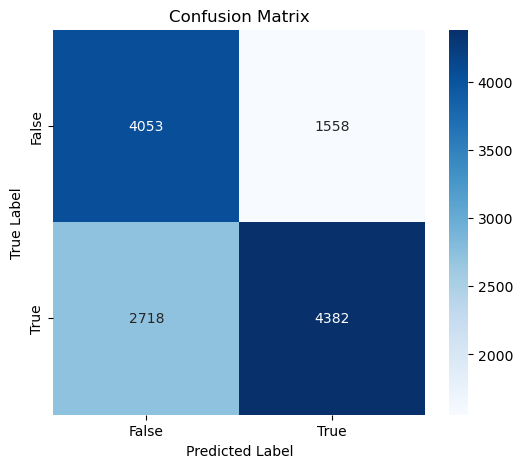

In [109]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=["False", "True"], yticklabels=["False", "True"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Again, the confusion matrix shows solid, but not good performance of the final model on the test data. The model predicts more instances of the data to be false while the majority of the data is actually true.
One point which stands out is that the False Positives could be minimized. This results is exactly what was wanted to achieve.